# Ferry Irwandi's YouTube Comments Sentiment Analysis

Source: https://youtu.be/1qDL8bPuj_I?si=KjUyirzyV6JrWaYv

Dataset From: 10 August 2025

## Setup

### Imports

In [65]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
import ssl
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import csv
import requests
from io import StringIO
from wordcloud import WordCloud
import os
from tqdm import tqdm
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


### Dependencies

#### NLTK

In [66]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/ekajaya740/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/ekajaya740/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/ekajaya740/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/ekajaya740/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/ekajaya740/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/ekajaya740/nltk_data...
[nltk_data]    |   Package 

True

#### Dictionary


In [67]:
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")


### Utility Functions

In [68]:
def separator():
    print('=' * 100)
    print()

def pie_chart_by_column(df, column):
    value_counts = df[column].value_counts()
    
    title = f'Distribution of {column}'
    
    plt.figure(figsize=(10, 6))

    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    plt.legend(title=column, loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.xlabel('Categories', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.gca().set_aspect('equal') 
    
    plt.title(title, fontsize=16, pad=20)
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    return value_counts

def wordcloud_by_column(df, column):    
    text = ' '.join(df[column].astype(str).tolist())
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {column}', fontsize=16)
    plt.show()

def show_classification_metrics(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    print(f"--- Metrics for {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    print("-" * (30 + len(model_name)))

def plot_accuracy_comparison(train_accuracy, test_accuracy, model_name="Model"):
    plt.figure(figsize=(8, 5))
    bars = plt.bar(['Training Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['#1f77b4', '#ff7f0e'])
    plt.ylabel('Accuracy Score')
    plt.title(f'{model_name} - Accuracy Comparison')
    plt.ylim(0, 1.05)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()


## Loading Dataset

### Open CSV

In [69]:
csv_location = "./dataset/youtube_comments_20250810_131638.csv"

df = pd.read_csv(csv_location)

total_nan = df.isnull().sum().sum()
print(f"Total NaN values: {total_nan}")

separator()

total_duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {total_duplicates}")

separator()


df.describe()

Total NaN values: 3

Total duplicate rows: 6



,likes,reply_count
count,13385.000000,13385.000000
mean,6.356294,0.360777
std,187.829162,9.557049
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,13707.000000,639.000000


### Cleaning Data

In [70]:
df_cleaned = df.copy()

df_cleaned = df_cleaned.drop_duplicates(subset=['id'])
df_cleaned = df_cleaned.dropna()
df_cleaned = df_cleaned.reset_index(drop=True)

df_cleaned.describe()

,likes,reply_count
count,13376.000000,13376.000000
mean,5.983777,0.334629
std,182.942281,9.060924
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,13707.000000,639.000000


## Preprocessing 

### Utilities

In [71]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['OMP_NUM_THREADS'] = str(mp.cpu_count())

factory = StemmerFactory()
stemmer = factory.create_stemmer()

mention_pattern = re.compile(r'@[A-Za-z0-9]+')
hashtag_pattern = re.compile(r'#[A-Za-z0-9]+')
rt_pattern = re.compile(r'RT[\s]')
url_pattern = re.compile(r"http\S+")
number_pattern = re.compile(r'[0-9]+')
non_word_pattern = re.compile(r'[^\w\s]')

listStopwords = set(stopwords.words('indonesian'))
listStopwords.update(stopwords.words('english'))
listStopwords.update([
    'yang', 'yg', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'untuk', 'tidak', 
    'ada', 'saya', 'kamu', 'dia', 'mereka', 'kita', 'aku', 'anda',
    'bisa', 'akan', 'sudah', 'belum', 'pernah', 'selalu', 'sering',
    'juga', 'sangat', 'sekali', 'hanya', 'cuma', 'hanya', 'lagi',
    'saja', 'saja', 'masih', 'telah', 'sedang', 'sedang', 'sambil',
    'dengan', 'atau', 'tetapi', 'namun', 'karena', 'sebab', 'jadi',
    'oleh', 'pada', 'sejak', 'sampai', 'tentang', 'tentang', 'melalui',
    'antara', 'antaranya', 'beserta', 'beserta', 'selain', 'selain',
    'adalah', 'ialah', 'yaitu', 'yakni', 'bahwa', 'kalau', 'jika',
    'bila', 'apabila', 'asal', 'asalkan', 'selama', 'sementara',
    'sebelum', 'sesudah', 'setelah', 'biar', 'biarpun', 'supaya',
    'agar', 'guna', 'untuk', 'guna', 'guna', 'guna', 'guna', 'guna',
    'gue', 'gua', 'gw', 'elu', 'elo', 'lu', 'loe', 'lo', 'ane',
    'aq', 'ak', 'kamu', 'kalian', 'kowe', 'koe', 'sampean', 
    'panjenengan',
    'kak', 'bro', 'sis', 'om', 'mbak', 'mbk', 'mimin', 'min',
    'mod', 'mas', 'masbro', 'tante', 'mbah', 'pak', 'ayah',
    'bu', 'mama', 'papa', 'bang', 'dek',
    'iya', 'iy', 'yes', 'oke', 'ok', 'okr', 'okeh', 'sip', 'siap',
    'gas', 'gaspol', 'gaskan', 'mantap', 'mantul', 'mantaap',
    'gak', 'nggak', 'ga', 'ngga', 'gpp', 'gapapa', 'gppp', 'gapap',
    'enggak', 'engga', 'tdk', 'kgk', 'kaga', 'kagak', 'g',
    'makasih', 'makasi', 'mks', 'thanks', 'thx', 'thankyou',
    'please', 'pls', 'sorry', 'maaf', 'mianhae', 'sori',
    'wkwk', 'wkwkwk', 'wk', 'haha', 'hahaha', 'hihi', 'hehe', 'huehue', 'xixi',
    'video', 'videos', 'channel', 'subscribe', 'subscribers',
    'like', 'likes', 'comment', 'comments', 'view', 'views',
    'watch', 'time', 'thanks', 'thank', 'please', 'much',
    'really', 'very', 'well', 'good', 'great', 'nice',
    'youtube', 'youtuber', 'content', 'content creator',
    'upload', 'uploader', 'stream', 'streamer', 'live',
    'trending', 'trend', 'viral', 'share', 'shares', 'nya', 'ya', 'si', 'dll', 'dg', 'dgn', 'df',
    'sih', 'krnnya', 'krnnya', 'krnnya', 'krnnya', 'kali', 'tri', 'isi', 'ala', 'utk', 'udh', 'jg', 'dr', 'b', 'doang', 'dah', 'te', 'tuh', 'gin', 'bata', 'erti', 'pas', 'bener', 'te', 'ken', 'klo', 'kl', 'ki'])


slang_words = {
    'ku': 'saya',
    "gue": "saya",
    "gua": "saya", 
    "gw": "saya",
    "elu": "kamu",
    "elo": "kamu",
    "lu": "kamu",
    "loe": "kamu",
    "lo": "kamu",
    "ane": "saya",
    "aq": "saya",
    "ak": "saya",
    "aku": "saya",
    "kamu": "anda",
    "kita": "kami",
    "kitorang": "kami",
    "kami": "kami",
    "kalian": "anda",
    "kowe": "kamu",
    "koe": "kamu",
    "sampean": "anda",
    "panjenengan": "anda",
    "kak": "kakak",
    "kakak": "kakak",
    "bro": "saudara",
    "brot": "saudara",
    "sis": "saudari",
    "mbak": "saudari",
    "mbk": "saudari",
    "mimin": "admin",
    "min": "admin",
    "mod": "moderator",
    "mas": "saudara",
    "masbro": "saudara",
    "om": "saudara",
    "tante": "saudari",
    "mbah": "saudara",
    "bapak": "bapak",
    "pak": "bapak",
    "ayah": "bapak",
    "ibu": "ibu",
    "bu": "ibu",
    "mama": "ibu",
    "papa": "bapak",
    "abang": "saudara",
    "bang": "saudara",
    "adik": "adik",
    "dek": "adik",
    "iya": "ya",
    "iy": "ya",
    "yes": "ya",
    "oke": "baik",
    "ok": "baik",
    "okr": "baik",
    "okeh": "baik",
    "ramay": "ramai",
    "guruyg": "guru",
    'sdm': 'sumber daya manusia',
    "sip": "baik",
    "siap": "siap",
    'gurunya': 'guru',
    'kalo': 'kalau',
    'emang': 'memang',
    'pr': 'pekerjaan rumah',
    'sd': 'sekolah dasar',
    'smp': 'sekolah menengah pertama',
    'sma': 'sekolah menengah atas',
    'smk': 'sekolah menengah kejuruan',
    'skrg': 'sekarang',
    'kayak': 'seperti',
    'ortu': 'orang tua',
    'pake': 'pakai',
    'ngajar': 'mengajar',
    'atur': 'mengatur',
    'ngomong': 'berbicara',
    'ngomongin': 'membicarakan',
    'udah': 'sudah',
    'bntu': 'bantu',
    'org': 'orang',
    'liat': 'lihat',
    'moga': 'semoga',
    'gnt': 'ganti',
    'temen': 'teman',
    'lulu': 'lulus',
    'tri didik': 'pendidikan',
    'laku': 'lakukan',
    'un': 'ujian nasional',
    'tuju': 'tujuan',
    'tau': 'tahu',
    'jabat': 'jabatan',
    'paham': 'mengerti',
    'susah': 'sulit',
    'guru guru': 'guru',
    'tuju': 'tujuan',
    'moga': 'semoga',
    'goblok': 'bodoh',
    'butuh': 'perlu',
    'indo': 'indonesia',
    'tolol': 'bodoh',
    'bego': 'bodoh',
    'gimana': 'bagaimana',
    'gk': 'tidak',
    'pa': 'apa',
    'sy': 'saya',
    'jd': 'jadi',
    'krn': 'karena',
    'aja': 'saja',
    'dah': 'sudah',
    'kek': 'seperti',
    'klo': 'kalau',
    'kl': 'kalau',
    'gin': 'begini',
    'dapet': 'dapat',
    'sdh': 'sudah',
    'gitu': 'begitu',
    'moga': 'semoga',
    'mending': 'lebih baik',
    'tp': 'tapi',
    'cuman': 'tapi',
    'tes': 'ujian',
    'sampe': 'sampai',
    'bgt': 'sangat',
    'banget': 'sangat',
    'ngerti': 'mengerti',
    'moga': 'semoga',
    'pinter': 'pintar',
    'lingkung': 'lingkungan',
    'karna': 'karena',
    'nyata': 'asli'
    }


def process_text(text):
    text_clean = mention_pattern.sub('', text)
    text_clean = hashtag_pattern.sub('', text_clean)  
    text_clean = rt_pattern.sub('', text_clean)
    text_clean = url_pattern.sub('', text_clean)
    text_clean = number_pattern.sub('', text_clean)
    text_clean = non_word_pattern.sub('', text_clean)
    text_clean = text_clean.replace('\n', ' ')
    text_clean = text_clean.translate(str.maketrans('', '', string.punctuation))
    text_clean = text_clean.strip()
    
    text_casefolding = text_clean.lower()
    
    words = text_casefolding.split()
    words_fixed = [slang_words.get(word, word) for word in words]
    text_slangwords = ' '.join(words_fixed)
    
    text_stemming = stemmer.stem(text_slangwords)
    
    text_tokenizing = word_tokenize(text_stemming)
    
    text_filtering = [token for token in text_tokenizing if token not in listStopwords]
    
    text_final = ' '.join(text_filtering)
    
    return {
        'text_clean': text_clean,
        'text_casefolding': text_casefolding,
        'text_slangwords': text_slangwords,
        'text_stemming': text_stemming,
        'text_tokenizing': text_tokenizing,
        'text_filtering': text_filtering,
        'text_final': text_final
    }


In [72]:
def process_text_ultra_fast(text):
    if not text or pd.isna(text):
        return pd.Series({
            'text_clean': '',
            'text_casefolding': '',
            'text_slangwords': '',
            'text_stemming': '',
            'text_tokenizing': [],
            'text_filtering': [],
            'text_final': ''
        })

    text_clean = text
    for pattern in [mention_pattern, hashtag_pattern, rt_pattern, url_pattern, 
                   number_pattern, non_word_pattern]:
        text_clean = pattern.sub('', text_clean)
    
    text_clean = text_clean.replace('\n', ' ')
    text_clean = text_clean.translate(str.maketrans('', '', string.punctuation))
    text_clean = text_clean.strip()
    
    if not text_clean:
        return pd.Series({
            'text_clean': text_clean,
            'text_casefolding': '',
            'text_slangwords': '',
            'text_stemming': '',
            'text_tokenizing': [],
            'text_filtering': [],
            'text_final': ''
        })
    
    text_casefolding = text_clean.lower()
    
    words = text_casefolding.split()
    words_fixed = [slang_words.get(word, word) for word in words]
    text_slangwords = ' '.join(words_fixed)
    
    text_stemming = stemmer.stem(text_slangwords)
    
    text_tokenizing = word_tokenize(text_stemming)

    text_filtering = [token for token in text_tokenizing if token not in listStopwords and token.strip()]
    
    text_final = ' '.join(text_filtering)
    
    return pd.Series({
        'text_clean': text_clean,
        'text_casefolding': text_casefolding,
        'text_slangwords': text_slangwords,
        'text_stemming': text_stemming,
        'text_tokenizing': text_tokenizing,
        'text_filtering': text_filtering,
        'text_final': text_final
    })

def process_chunk(chunk_data):
    return chunk_data.apply(process_text_ultra_fast)

def optimized_preprocessing(df, n_processes=None):
    if n_processes is None:
        n_processes = min(mp.cpu_count() - 1, 8)
    
    chunk_size = max(1, len(df) // n_processes)
    chunks = [df['text'].iloc[i:i+chunk_size] for i in range(0, len(df), chunk_size)]
    
    with ProcessPoolExecutor(max_workers=n_processes) as executor:
        results = list(tqdm(
            executor.map(process_chunk, chunks), 
            total=len(chunks),
            desc="Processing chunks"
        ))
    
    final_results = pd.concat(results, ignore_index=True)
    
    return final_results

def run_single_threaded(df):
    print("Running single-threaded ultra-optimized version...")
    tqdm.pandas(desc="Processing texts")
    return df['text'].progress_apply(process_text_ultra_fast)


preprocessing_results = run_single_threaded(df_cleaned)
df_cleaned = pd.concat([df_cleaned, preprocessing_results], axis=1)

df_cleaned.head()


Running single-threaded ultra-optimized version...


Processing texts: 100%|██████████| 13376/13376 [29:33<00:00,  7.54it/s] 


,id,author,date,text,likes,reply_count,is_reply,text_clean,text_casefolding,text_slangwords,text_stemming,text_tokenizing,text_filtering,text_final
0,UgyDaegI4nlyU3VPtwN4AaABAg,@ferryirwandi,2024-10-10T09:02:59Z,"hallo warga sipil sekalian, selamat menonton",4961,353,False,hallo warga sipil sekalian selamat menonton,hallo warga sipil sekalian selamat menonton,hallo warga sipil sekalian selamat menonton,hallo warga sipil sekali selamat tonton,"[hallo, warga, sipil, sekali, selamat, tonton]","[hallo, warga, sipil, selamat, tonton]",hallo warga sipil selamat tonton
1,UgyDaegI4nlyU3VPtwN4AaABAg.A9PXST3-y1GA9PXVwN07dK,@KaebyDS,2024-10-10T09:03:28Z,Selamat makan,42,0,True,Selamat makan,selamat makan,selamat makan,selamat makan,"[selamat, makan]","[selamat, makan]",selamat makan
2,UgyDaegI4nlyU3VPtwN4AaABAg.A9PXST3-y1GA9PXXECSUqA,@raditt.27579,2024-10-10T09:03:38Z,okr,16,0,True,okr,okr,baik,baik,[baik],[],
3,UgyDaegI4nlyU3VPtwN4AaABAg.A9PXST3-y1GA9PXdPOTaZ3,@hirumayoichi2625,2024-10-10T09:04:37Z,Bagaimana pendapat Bang Ferry tentang kegiatan...,13,0,True,Bagaimana pendapat Bang Ferry tentang kegiatan...,bagaimana pendapat bang ferry tentang kegiatan...,bagaimana pendapat saudara ferry tentang kegia...,bagaimana dapat saudara ferry tentang giat okt...,"[bagaimana, dapat, saudara, ferry, tentang, gi...","[saudara, ferry, giat, oktober]",saudara ferry giat oktober
4,UgyDaegI4nlyU3VPtwN4AaABAg.A9PXST3-y1GA9PXzT80NlM,@muhammadprajawanto8749,2024-10-10T09:07:38Z,Akan ada the people power,6,0,True,Akan ada the people power,akan ada the people power,akan ada the people power,akan ada the people power,"[akan, ada, the, people, power]","[people, power]",people power


### Polarity Analysis

#### Utilities

In [73]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
        
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity=''

    if (score >= 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'

    return score, polarity

#### Analysis

negative    6929
positive    6447
Name: polarity, dtype: int64


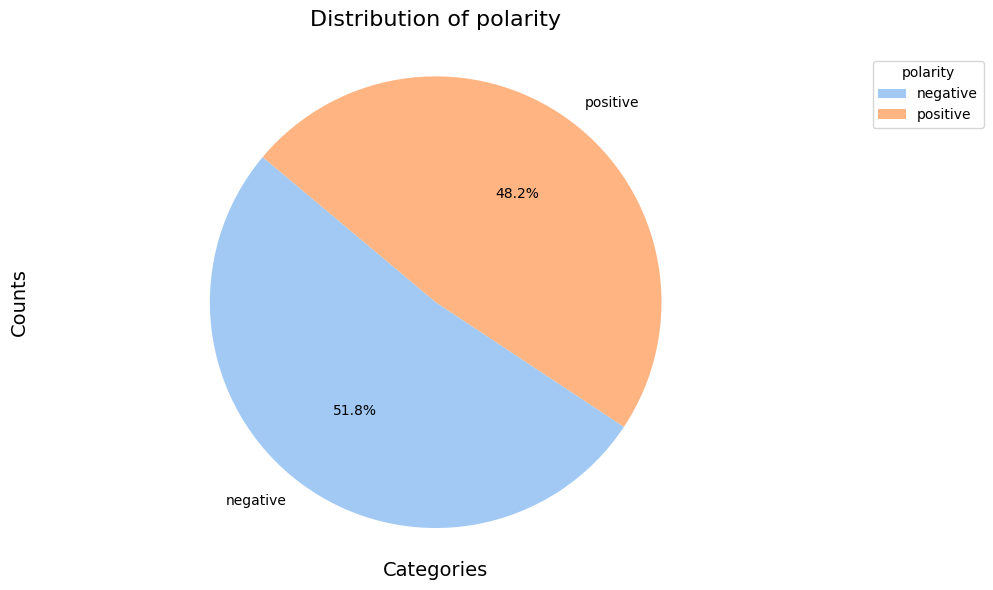

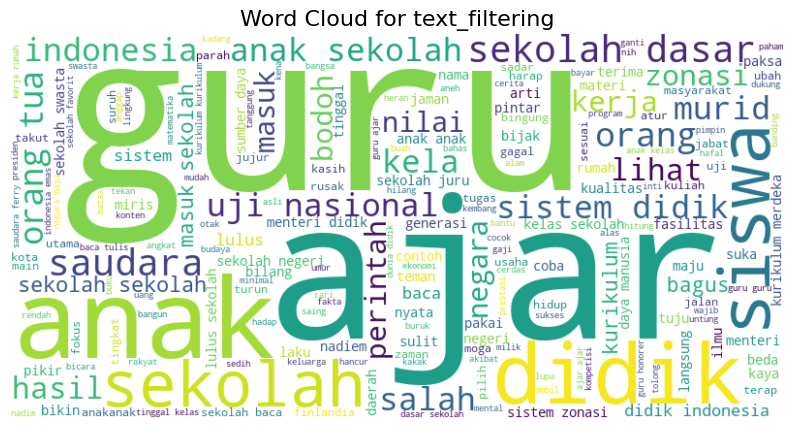

In [74]:
results = df_cleaned['text_filtering'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df_cleaned['polarity_score'] = results[0]
df_cleaned['polarity'] = results[1]
print(df_cleaned['polarity'].value_counts())

pie_chart_by_column(df_cleaned, 'polarity')
separator()
wordcloud_by_column(df_cleaned, 'text_filtering')
separator()


### Feature Extractions

In [ ]:
def extract_tfidf_features(df, text_column='text_final', target_column='polarity', 
                          max_features=400, min_df=17, max_df=0.8, ngram_range=(1, 2), 
                          test_size=0.2, random_state=42):
    
    X = df[text_column]
    y = df[target_column]
    
    tfidf = TfidfVectorizer(
        max_features=max_features,
        min_df=min_df,
        max_df=max_df,
        ngram_range=ngram_range
    )
    
    X_tfidf = tfidf.fit_transform(X)
    

    df_features = pd.DataFrame(
        X_tfidf.toarray(), 
        columns=tfidf.get_feature_names_out()
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, 
        test_size=test_size, 
        random_state=random_state
    )
    
    return {
        'tfidf_vectorizer': tfidf,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_names': tfidf.get_feature_names_out(),
        'df_features': df_features,
        'X_tfidf_full': X_tfidf 
    }




#### Model Training

In [76]:
def train_logistic_regression_classifier(X_train, X_test, y_train, y_test, 
                                       random_state=42, 
                                       max_iter=1000,
                                       C=1.0,  
                                       penalty='l2',  
                                       solver='liblinear'):
    
    
    lr_classifier = LogisticRegression(
        random_state=random_state,
        max_iter=max_iter,
        C=C,
        penalty=penalty,
        solver=solver,
        class_weight="balanced"
    )

    lr_classifier.fit(X_train, y_train)

    
    y_pred_train = lr_classifier.predict(X_train)
    y_pred_test = lr_classifier.predict(X_test)
    
    y_pred_proba_train = lr_classifier.predict_proba(X_train)
    y_pred_proba_test = lr_classifier.predict_proba(X_test)
    
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    return {
        'model': lr_classifier,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'y_pred_proba_train': y_pred_proba_train,
        'y_pred_proba_test': y_pred_proba_test,
        'accuracy_train': accuracy_train,
        'accuracy_test': accuracy_test,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

def train_random_forest_classifier(X_train, X_test, y_train, y_test, 
                                   n_estimators=100, 
                                   max_depth=None,     
                                   min_samples_leaf=1, 
                                   random_state=42,
                                   n_jobs=-1):         

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state,
        n_jobs=n_jobs
    )


    print("Training Random Forest model...")
    rf_classifier.fit(X_train, y_train)
    print("Training complete.")


    y_pred_train = rf_classifier.predict(X_train)
    y_pred_test = rf_classifier.predict(X_test)
    
    y_pred_proba_train = rf_classifier.predict_proba(X_train)
    y_pred_proba_test = rf_classifier.predict_proba(X_test)
    

    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)


    return {
        'model': rf_classifier,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'y_pred_proba_train': y_pred_proba_train,
        'y_pred_proba_test': y_pred_proba_test,
        'accuracy_train': accuracy_train,
        'accuracy_test': accuracy_test,
        'X_test': X_test, 
        'y_test': y_test 
    }

def train_svm_classifier(X_train, X_test, y_train, y_test, 
                         C=1.0,              
                         kernel='linear',      
                         probability=True,   
                         random_state=42,
                         gamma='scale'
                         ):
    svm_classifier = SVC(
        C=C,
        kernel=kernel,
        probability=probability,
        random_state=random_state,
        gamma=gamma
    )

    svm_classifier.fit(X_train, y_train)
    print("Training complete.")

    y_pred_train = svm_classifier.predict(X_train)
    y_pred_test = svm_classifier.predict(X_test)
    
    y_pred_proba_train = svm_classifier.predict_proba(X_train)
    y_pred_proba_test = svm_classifier.predict_proba(X_test)
    
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    return {
        'model': svm_classifier,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'y_pred_proba_train': y_pred_proba_train,
        'y_pred_proba_test': y_pred_proba_test,
        'accuracy_train': accuracy_train,
        'accuracy_test': accuracy_test,
        'X_test': X_test,
        'y_test': y_test
    }




### Results

#### TF-IDF with Linear Regression

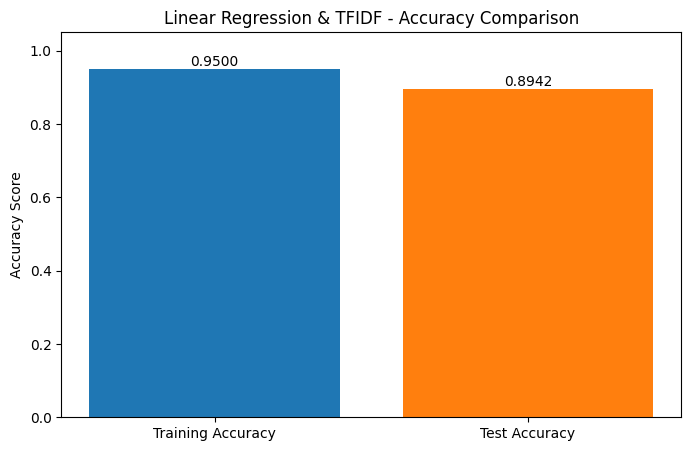

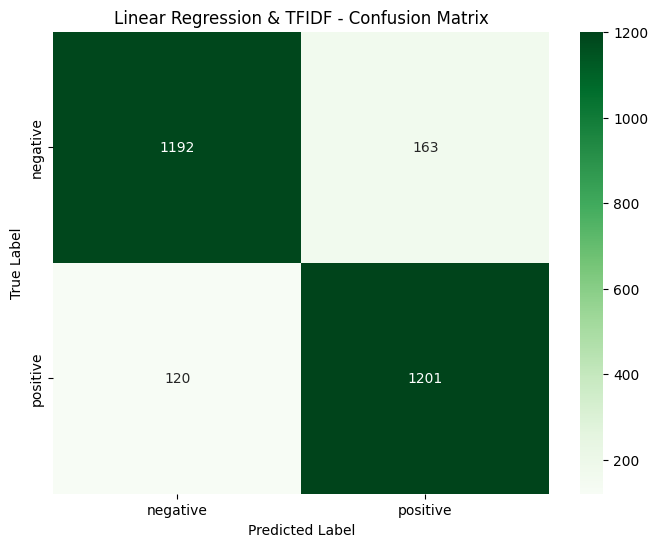

In [77]:
tfidf = extract_tfidf_features(df_cleaned, test_size=0.2, max_features=3000)

lr_tfidf_results = train_logistic_regression_classifier(
    tfidf['X_train'],
    tfidf['X_test'],
    tfidf['y_train'],
    tfidf['y_test'],
    C=10
)

plot_accuracy_comparison(
    train_accuracy=lr_tfidf_results['accuracy_train'],
    test_accuracy=lr_tfidf_results['accuracy_test'],
    model_name="Linear Regression & TFIDF"
)

plot_confusion_matrix(
    y_true=lr_tfidf_results['y_test'],
    y_pred=lr_tfidf_results['y_pred_test'],
    class_names=lr_tfidf_results['model'].classes_,
    model_name="Linear Regression & TFIDF",
)


#### TF-IDF with Random Forest

Training Random Forest model...
Training complete.


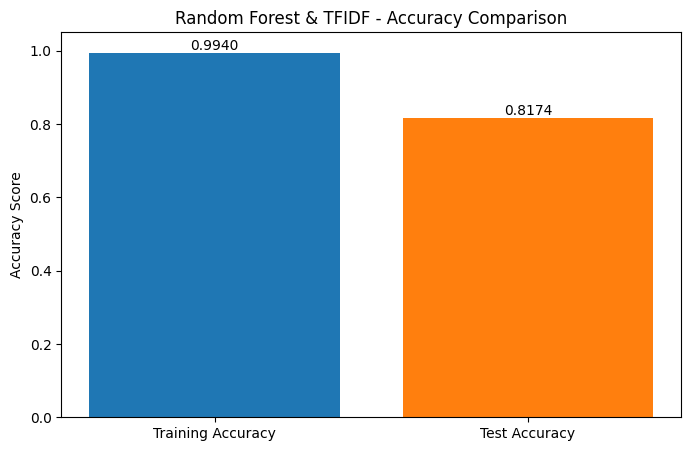

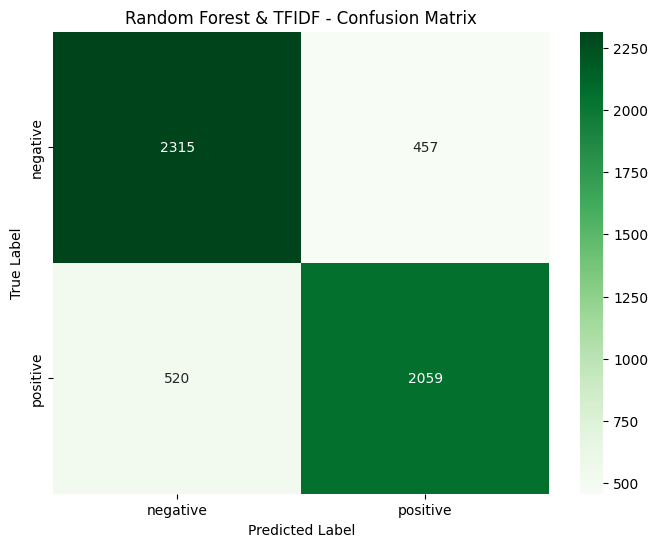

In [78]:
tfidf = extract_tfidf_features(df_cleaned, test_size=0.4, max_features=3000)

rf_tfidf_results = train_random_forest_classifier(
    tfidf['X_train'],
    tfidf['X_test'],
    tfidf['y_train'],
    tfidf['y_test'],
    n_estimators=1000,
)

plot_accuracy_comparison(
    train_accuracy=rf_tfidf_results['accuracy_train'],
    test_accuracy=rf_tfidf_results['accuracy_test'],
    model_name="Random Forest & TFIDF"
)

plot_confusion_matrix(
    y_true=rf_tfidf_results['y_test'],
    y_pred=rf_tfidf_results['y_pred_test'],
    class_names=rf_tfidf_results['model'].classes_,
    model_name="Random Forest & TFIDF",
)

#### TFIDF with Support Vector Machine

Training complete.


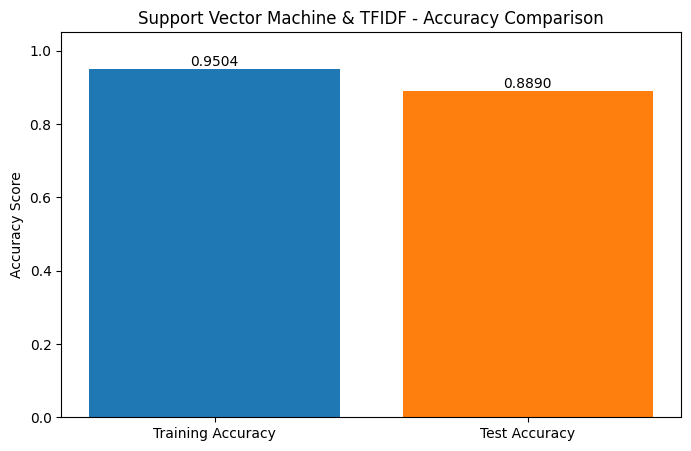

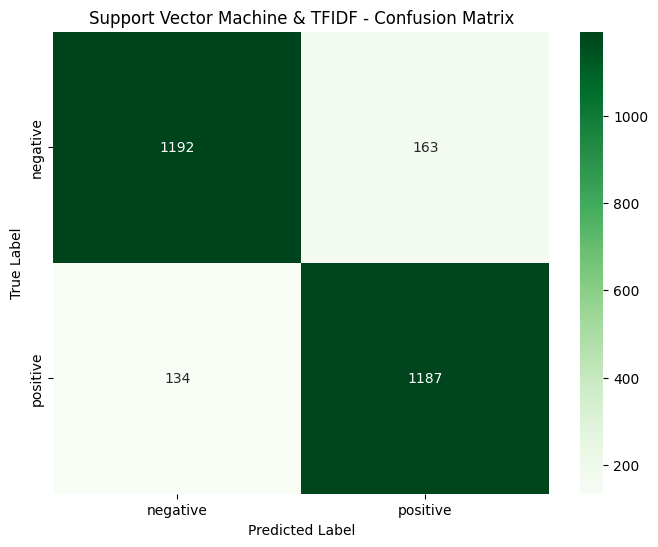

In [79]:
tfidf = extract_tfidf_features(df_cleaned, test_size=0.2, max_features=3000)

svm_tfidf_results = train_svm_classifier(
    tfidf['X_train'],
    tfidf['X_test'],
    tfidf['y_train'],
    tfidf['y_test'],
    C=10,
    gamma=0.1,
    kernel="rbf"
)

plot_accuracy_comparison(
    train_accuracy=svm_tfidf_results['accuracy_train'],
    test_accuracy=svm_tfidf_results['accuracy_test'],
    model_name="Support Vector Machine & TFIDF"
)

plot_confusion_matrix(
    y_true=svm_tfidf_results['y_test'],
    y_pred=svm_tfidf_results['y_pred_test'],
    class_names=svm_tfidf_results['model'].classes_,
    model_name="Support Vector Machine & TFIDF",
)